# Simulating the Brazil Nut Effect

## Introduction

### Granular Convection

Granular materials exhibit an array of complex behaviours that defy simple classifications such as solid, liquid or gas. One particularly interesting phenomena is the Brazil Nut effect. In a container of a granulated medium, vibrating, agitating or shaking the container will result in spontaneous segregation of sizes. Counterintuitively, larger granules tend to rise to the surface as a result of a combination of granular convection and size-dependent percolation (Hong et al., 2001; Moss et al., 2023).

When the granular medium is shaken, it creates a circular pattern similar to convection in fluids, causing the particles at the bottom to rise to the top and vice versa in a cyclical pattern (Moss et al., 2023). Multiple studies also show that an important factor that contributes to the effect is the existance of friction along the walls (Knight et al., 1993 and Maurel et al., 2017). The gaps within the medium are also disrupted, creating space under the larger particles for smaller particles to fall into and fill up, thereby pushing the larger particles upward and keeping them at the surface (Hong et al., 2001). It is also interesting to note that the reverse <em>Brazil Nut effect</em> does occur in specific conditions (Knight et al. 1993).

### Significance of Granular convection

The understanding of the effect is considerably important in many fields ranging from geophysics and pharmaceuticals to materials handling. For example, in pharmaceuticals, size segregation would help to filter the smaller granules which would increase tensile strenth of tablets (Herting et al., 2001). Or in Geology, soil and sand layers can seperate due to the vibrations caused by earthquakes. Studying granular flows can help predict how the granular layers behave to prevent crisis (Taslimian, 2024). It exemplifies how non-equilibrium dynamics and local interactions in granular interactions can give rise to emergent macroscopic order.

### Project Objectives

This project aims to simulate this phenomenon in 2D using a particle based model with a focus on reproducing the <em>Brazil Nut Effect</em> through controlled "shaking" of the medium. The goal is to observe the upward movement of the larger particles in a bed of smaller ones, as well as explore how different parameters could influence the dynamics. Utilising computaional methods that would accomplish 

The simulation will utilise computaional methods rooted in the <em>Discrete Element Method</em> framework. It would enable the explicit modelling of the interactions between particles, represented as disks, and boundaries creating a robust, detailed and accurate simulation of the system. 

Ultimately, the project works to highlight how simple local interactions can give rise to macroscopic phenomena.

## Methodology

### Discrete Element Method

The <em>Discrete Element Method</em> (DEM) is a computational technique used in numerical simulations of particles where the interactions are modelled as a dynamic process(Thornton et al. 2015, p.2). Unlike contrinuum approaches, DEM treats each particle as an individual entity, allowing for the explicit modelling of collisions in the system. The contact models account for both normal and tangential forces. The motion of the particles are obtained by integrating Newton's laws of motion over time using methods such as the <em>velocity verlet</em> method. 

 

### Time-Step Driven Simulation

The simulation adopts a time-step driven approach, in which the entire duration of the systems evolution is discretised into small increments where the dynamics are computed iteratively at each step. A time-tep formulation is more appropriate than an event driven simulation due to its "dense" nature amd sustained contact interactions when particles settle. The collision times of the particles tend to approach a limit $t\to0$. In this regime, an event driven algorithm, which relies on resolving discrete collisions become inapplicable (Thornton, 2015, p.2). The time-step method therefore provides a better framework for capturing the dynamics of this system.

### Velocity Verlet

The velocity verlet method is a numerical integration algorithm rooted in newtonian dynamics. It updates both positions and velocities while ensuring stability.  Compared to other integration techniques, it is computationally efficient while maintaining good accuracy and stability(Hairer et al., 2003). 

Using the acceleration, $a$, at time, $t$, the velocity, $v$ of the particle at the midpoint of each time step is taken. This midpoint velocity is used to calculate the 

Using Newton's second law, $F = m\ddot{x}(t)$, the algorithm is as follows:
\begin{equation}
\begin{aligned}
ma(t) &= F(t, x(t), v(t))  \\
v\left(t + \tfrac{1}{2}\Delta t\right) &= v(t) + \tfrac{1}{2} a(t) \Delta t, \\
x\left(t + \Delta t\right) &= x(t) + v\left(t + \tfrac{1}{2}\Delta t\right) \Delta t, \\
ma(t + \Delta t) &= F(t + \Delta t, x(t + \Delta t), v(t + \Delta))\\
v(t + \Delta t) &= v\left(t + \tfrac{1}{2}\Delta t\right) + \tfrac{1}{2} a(t + \Delta t)\, \Delta t.
\end{aligned}
\end{equation}



Noting that, in this simulation, the force, $F$, does not change with time, so acceleration, $a$, remains constant. And the algorithm is simplfied to:
\begin{equation}
\begin{aligned}
v\left(t + \tfrac{1}{2}\Delta t\right) &= v(t) + \tfrac{1}{2} a \Delta t, \\
x\left(t + \Delta t\right) &= x(t) + v\left(t + \tfrac{1}{2}\Delta t\right) \Delta t, \\
v(t + \Delta t) &= v\left(t + \tfrac{1}{2}\Delta t\right) + \tfrac{1}{2} a \Delta t.
\end{aligned}
\end{equation}

This algorithm is applied iteratively, ensuring that both velocity and positions evolve consistently over time.

### Overview of Each Time-Step

The implementation of the <em>velocity verlet</em> framework in the time-driven simulation is conceptionally straightforward. After initialising the simulation, the the algorithm is applied to compute the new velocities and positions at each time step. In each time step the simulation would run:

In [7]:
def verlet(xs, ys, xl, yl, vxs, vys, vxl, vyl):
    vysmid = vys + g * (dt / 2)
    vylmid = vyl + g * (dt / 2)
    ys += vysmid * dt
    xs += vxs * dt
    yl += vylmid * dt
    xl += vxl * dt
    vys = vysmid +  g * dt
    vyl = vylmid +  g * dt
    return xs, ys, xl, yl, vxs, vys, vxl, vyl

Following the velocity verlet, the algorithm is required to determine wether collisions have occured. In this project, collisions could occur between particles(both between equal size particles and different sized particles) or particle-wall contact. Efficient detection of events is crucial in order for the simulation to run smoothly. 

To speed up the search process, a uniform grid search algorithm is employed (Coutinho, 2013, p.45). Here the simulation space  is divided into a uniform grid with cell size approximately the sum of radii of 2 particles interacting. The particles are assigned to a cell based on their coordinates.

In [8]:
def assign_to_grid(x, y, cell_size):
    grid = defaultdict(list)
    for i, (x, y) in enumerate(zip(xs, ys)):
        cx = int(x // cell_size)
        cy = int(y // cell_size)
        grid[(cx, cy)].append(i)
    return grid

Next, a function to identify only potential collisions by examining only particles within the cell or directly adjacent cell. 

In [9]:
def collision_candidates(x, y, cell_size):
    grid = assign_to_grid(x, y, cell_size)
    candidates = []
    for (cx, cy), particles in grid.items():
        # check current cell + 8 neighbors
        for dx in [-1, 0, 1]:
            for dy in [-1, 0, 1]:
                neighbor = (cx+dx, cy+dy)
                if neighbor in grid:
                    for i in particles:
                        for j in grid[neighbor]:
                            if i < j:  # avoid duplicates
                                candidates.append((i, j))
    return candidates

Now, for each time step, the simulation has to only search through the possible candidates for collisions for each particle instead of searching for every other particle. This significantly reduces the computational effort needed as the system avoids pairwise collisions accross the entire system.

For a particle collision, the algorithm searches through the earlier candidates of collisions for overlaps. If the distance is less than the sum of the radii of the 2 particles, then the particles would have collided within the last time step. The overlap has to be resolved with a function that would move the particles in the direction parallel vector connecting the centres to the point where the surfaces of the particles meet.

In [10]:
#overlap function
def overlap(x1, x2, y1, y2, dx, dy, dist, r1, r2):
    # overlap distance
    overlap = 0.5 * (r1 + r2 - dist)
    
    # direction of overlap
    nx, ny = dx / dist, dy / dist
    
    # correction of overlap
    x1 += overlap * nx
    y1 += overlap * ny
    x2 -= overlap * nx
    y2 -= overlap * ny
    
    return x1, x2, y1, y2

After each collision, the velocities of the particle is updated. The velocity of the particle is broken into 2 parts, one parallel $\parallel$ to the line joining the centres of the 2 disks and one perpendicular $\perp$ to this line. Since the collision axis is not aligned with the cartesian axis, the vector dot product is used to project the velocities onto the parallel vector. When collided, the $v_{\parallel}$ of the colliding particles are resolved with principles of impulse and momentum (Coutinho, 2013, p.112-113) with an arbitrary damping constant to account for inelasticity while $v_{\perp}$ of the respective particles remains unchanged as the collosions are assumed to be frictionless.

In [11]:
def sl_v_update(xs, ys, vxs, vys, xl, yl, vxl, vyl, m, M, dx, dy):
    dvx = vxs - vxl
    dvy = vys - vyl
    dist2 = dx**2 + dy**2
    # projection factor
    dot = dvx*dx + dvy*dy
    factor_i = (2*M / (m + M)) * (dot / dist2)
    factor_j = (2*m / (m + M)) * (dot / dist2)

    # update velocities with damping = 0.5
    vxs -= 0.8 * factor_i * dx
    vys -= 0.8 * factor_i * dy
    vxl += 0.8 * factor_j * dx
    vyl += 0.8 * factor_j * dy
    return vxs, vys, vxl, vyl

In addition to particle-particle collisions, it is also necessary to account for collisions between the particle and wall. Operating on the same principle, when the position of the particles exceed the boundaries, the algorithm would reposition the particle back within the boundaries. The velocity update this then performed. The velocity of the particle is decomposed into $v_{\parallel}$ and $v_{\perp}$ with respect to the wall surface. Since the walls and the velocities are already in cartesian coordianates, this simplifies the process.

The $v_{\perp}$ is reflected in the opposite direction with a damping constant while the $v_{\parallel}$ is modified with a friction coefficient. The inclusion of friction is particularly important as multiple studies have shown its influence on the phenomenon.

In [12]:
def bound_conditions_s(xs, ys, vxs, vys):
    if xs < smallR:
        xs = smallR
        vxs = - d * vxs
        vys *= f
    if xs > Lx - smallR:
        xs = Lx - smallR
        vxs = - d * vxs
        vys *= f
    if ys > Ly - smallR:
        ys = Ly - smallR
        vys = - d * vys
        vxs *= f
    if ys < smallR :
        ys = smallR 
        vys = - d * vys
        vxs *= f
    return xs, ys, vxs, vys,
def bound_conditions_l(xl, yl, vxl, vyl):
    if xl < largeR:
        xl = largeR
        vxl = - d * vxl
        vyl *= f
    if xl > Lx - largeR:
        xl = Lx - largeR
        vxl = - d * vxl
        vyl *= f
    if yl > Ly - largeR:
        yl = Ly - largeR
        vyl = - d * vyl
        vxl *= f
    if yl < largeR:
        yl = largeR 
        vyl = -d * vyl
        vxl *= f
    return  xl, yl, vxl, vyl

Here it is good to note that the choice of size of the time step is important. It determines whether the algorithm is able to find and resolve the collisions. If the time step is too big, the particles would pass through each other and the algorithm would mistakenly resolve the collision the wrong way or miss it entirely. 

For the simulation to explore the <em>Brazil Nut Effect</em>, the simulation has to implement a vertical vibration or a "shake" which serves as the driving mechanism for the phenomenon. For this simulation, a "kick" is given to the particles in contact with the floor of the simulation. This is accurate to shaking a  granular bed since the contact forces exerted by the vibrating floor is the primary source of energy input to the system. By having the "kick" restricted to the base, the simulation would reproduce the dynamics of the phenomenon where vibration propogates upwards from the base. 

In [13]:
def kick(ys, vys, yl, vyl, k): 
    for i in range(Nsmall):
        if ys[i] - smallR < 1e-4:
            vys[i] += k
    for i in range(Nlarge):
        if yl[i] - largeR < 1e-4:
            vyl[i] += k
    return vys, vyl

The kick is introduced periodically in the simulation to imitate shaking of the system.

These steps are reiterated in each time step to properly simulate the dynamics of the phenomenon. The code as a whole can be found in the appendix.

## Exploring the Simulation

The parameters of the simulation are all editable variables which could be used to explore the <em>Brazil Nut effect</em>. In this project, we will explore the effect of the "shake" given to the system by varying the magnitude of the kick to explore the conditions for which the <em>Brazil Nut Effect</em> would occur. For this experiment, the number of large particles is 1 while the number of small particles is 75.

The results are shown below.

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
yl= np.array([1.15637536, 1.16079416, 2.66836639, 6.90381038, 1.39410479, 6.98654099, 7.94957065, 7.23604703, 8.25331228])

Plotting the Magnitude of the shake against the height of the Large Particle at the end of the simulation gives:

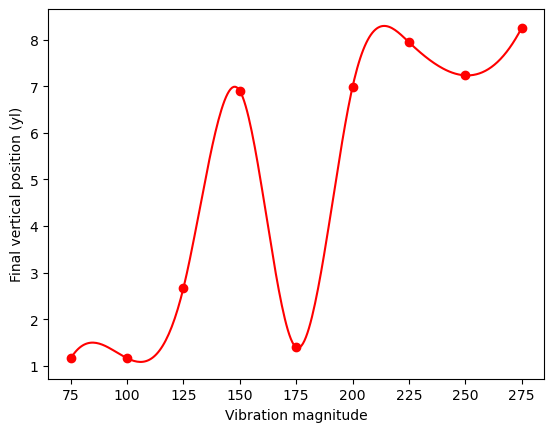

In [39]:
mag = np.array([75, 100, 125, 150, 175, 200, 225, 250, 275])
plt.plot(mag, yl, 'ro')
plt.xlabel("Vibration magnitude")
plt.ylabel("Final vertical position (yl)")
# Create an interpolation function (cubic spline)
f_interp = interp1d(mag, yl, kind='cubic')
mag_new = np.linspace(mag.min(), mag.max(), 300)
yl_new = f_interp(mag_new)
plt.plot(mag_new, yl_new, 'r-', label="cubic interp1d")

Note that the same initail conditions were applied for all runs in this experiment, the large particle starts at the bottom of the pile near the centre of the box. The simulation was programmed to run for 10000 steps to ensure sufficient evolution of the system.

The results seem to indicate a minimal magnitude of vibration required for the effect to take place, which seem to be in the 100-125 range. Below this threshold, the large particle stays at the base of the pile and does not move up. This suggests that the energy of the kick was insufficient to bump the larger particle up in order for the smaller particles to fill in the cavity beneath, which is crucial in the occurence of the <em>Brazil Nut Effect</em>. 

Futhermore, The vertical displacement of the large particle also tops out at a position of $y\approx7$ which suggests that it is the height of the bed of small particles. This would imply that increasing the vibration magnitude would not yield a higher vertical position.

The results suggest that the range of values that meaningfully contribute to the difference in vertical displacement of the large particle at the end of the simulation would lie between $\approx 100 \to 200$. Interestingly, the case that corresponds to vibration magnitude$=175$ seem to be an outlier. Upon closer inspection of the animation, it was noticed that the large particle seems to get trapped if it is near to the sides preventing the upward migration. Another interesting note is that for the effects to occur consistently and reliably, the system has to settle after every kick. Without time for the bed to settle, the particles would not evenly distribute the upward force to the large particle needed for the effect to take place.

Removing the outlier from the data and adding a polycurve fit to the contributing range yields:

0.023197445884750548 3.4431801161711646
[ 0.0613166  -4.38438266]


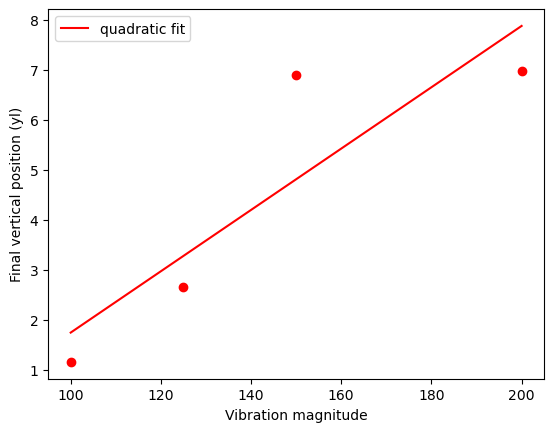

In [48]:
yl= np.array([1.16079416, 2.66836639, 6.90381038, 
             6.98654099])
mag = np.array([100, 125, 150, 200])
plt.plot(mag, yl, 'ro')
plt.xlabel("Vibration magnitude")
plt.ylabel("Final vertical position (yl)")
def model(x, a, b):
    return a*x + b
popt, pcov = curve_fit(model, mag, yl)
mag_fit = np.linspace(mag.min(), mag.max(), 300)
yl_fit = model(mag_fit, *popt)
plt.plot(mag_fit, yl_fit, 'r-', label="quadratic fit")
plt.legend()
print(np.sqrt(pcov[0,0]), np.sqrt(pcov[1,1]))
print(popt)


The equation of the fitted line is $y = 0.06\pm0.02x - 4.4\pm3.4$. This would make sense as the increased magnitude of vibration would send more energy upwards meaning the large particle would require fewer kicks in order to reach the top of the pile.

### Limitations to the System

While the system is succesful at recreating the key aspects of the <em>Brazil Nut Effect</em>, several limitations need to be addressed. First, the system is represented on a 2-dimensional plane. This simplifies interactions and might not capture fully the comploexity of 3-dimensional granular dynamics. Secondly, the choice of arbitrary constants such as the frictional constant, damoing constant and gravity was not calibrated to experimental data which would not accurately reflect the physical interactions in reality. Thirdly, the simulation assumes the granules are perfect spheres which is rarely the case in real life. This also does not accurately reflect granular dynamics in reality. Finally, computational constraint required the simulation to use a finite number of steps and particles which could restrict the observation or resolution of the interactions occuring. 

These limitations suggest that further refinement is required to provide more qualitative insights into the <em>Brazil Nut Effect</em>.

## Conclusion

The simulation managed to capture the dynamics of the phenomenon and recreated the <em>Brazil NutEffect</em> with somewhat accurate physics. By applying a controlled vertical vibration, the simulation was successfull at recreating the granular convection, even highlighting the threshold magnitude of vibration for the phenomenon to occur. Observations also revealed the importance of the settling of the system and the role that the boundaries play in influencing the effect. Although the model is simple, it highlights the effects of local interactions on macroscopic phenomena.  

## References

1. Coutinho, M. G., & SpringerLink. (2013). Guide to Dynamic Simulations of Rigid Bodies and Particle Systems. Springer London. https://doi.org/10.1007/978-1-4471-4417-5

2. Hairer E, Lubich C, Wanner G. Geometric numerical integration illustrated by the Störmer–Verlet method. Acta Numerica. 2003;12:399-450. doi:10.1017/S0962492902000144

3. Herting, M. G., & Kleinebudde, P. (2007). Roll compaction/dry granulation: Effect of raw material particle size on granule and tablet properties. International Journal of Pharmaceutics, 338(1), 110–118. https://doi.org/10.1016/j.ijpharm.2007.01.035

4. Hong, D. C., Quinn, P. V., & Luding, S. (2001). Reverse Brazil Nut Problem: Competition between Percolation and Condensation. Physical Review Letters, 86(15), 3423–3426. https://doi.org/10.1103/PhysRevLett.86.3423

5. Knight, J. B., Jaeger, H. M., & Nagel, S. R. (1993). Vibration-induced size separation in granular media: The convection connection. Physical Review Letters, 70(24), 3728–3731. https://doi.org/10.1103/PhysRevLett.70.3728

7. Maurel, C., Ballouz, R.-L., Richardson, D. C., Michel, P., & Schwartz, S. R. (2017). Numerical simulations of oscillation-driven regolith motion: Brazil-nut effect. Monthly Notices of the Royal Astronomical Society, 464(3), 2866–2881. https://doi.org/10.1093/mnras/stw2641

8. Moss, J., & Glovnea, R. (2023). Behavioural responses to horizontal vibrations of quasi-2D ideal granular beds: an experimental approach. Granular Matter, 25(4), Article 63. https://doi.org/10.1007/s10035-023-01354-7

9. Taslimian, Rohollah (2024). "Turbulent-Fluid-Based Simulation of Dynamic Liquefaction Using Large Deformation Analysis of Solid Phase". American Journal of Engineering and Applied Sciences. 17 (2): 51–55. ISSN 1941-7039.

10. Thornton, C. (2015). Granular Dynamics, Contact Mechanics and Particle System Simulations: A DEM study (1st ed. 2015, Vol. 24). Springer Nature. https://doi.org/10.1007/978-3-319-18711-2





## Appendix

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Circle

# Parameters
Lx, Ly = 5, 10     # Size of Box
Nsmall = 75     # no. of small particles
Nlarge = 1     # no. of large particles
smallR = 0.3     # size of small particles
largeR = 0.6     # Size of large particles
rho = 2     # Density of particles
m = np.pi * smallR**2 * rho     # Mass of small particle
M = np.pi * largeR**2 * rho     # mass of large particle
f = 0     # friction
d = 0.8     # damping
g = -20     # gravity
dt = 0.001     # size of time step
T = 10     # total duration
step = int(T/dt)     # no. of time steps

In [ ]:
# Initialize positions with boundaries
# Small particles
xs = np.random.rand(Nsmall) * (Lx - 2 * smallR) + smallR
ys = np.random.rand(Nsmall) * (Ly - 2 * smallR) + smallR
vxs = np.zeros(Nsmall)
vys = np.zeros(Nsmall)

# Large particles
xl = np.random.rand(Nlarge) + 2
yl = np.random.rand(Nlarge) 
vxl = np.zeros(Nlarge)
vyl = np.zeros(Nlarge)

fig, ax = plt.subplots()
for i in range(Nsmall):
    disk = Circle((xs[i], ys[i]) , radius=smallR, color='b')
    ax.add_patch(disk)
for i in range(Nlarge):
    disk = Circle((xl[i], yl[i]), radius=largeR, color='r')
    ax.add_patch(disk)    
ax.set_xlim(0, Lx)
ax.set_ylim(0, Ly)
ax.set_aspect('equal')

In [ ]:
#overlap function
def overlap(x1, x2, y1, y2, dx, dy, dist, r1, r2):
    # overlap distance
    overlap = 0.5 * (r1 + r2 - dist)
    
    # direction of overlap
    nx, ny = dx / dist, dy / dist
    
    # correction of overlap
    x1 += overlap * nx
    y1 += overlap * ny
    x2 -= overlap * nx
    y2 -= overlap * ny
    
    return x1, x2, y1, y2

In [ ]:
def pp_v_update(vxi, vyi, vxj, vyj, rij, dx, dy):
    # update velocities with damping = 0.5
    dot = ((vxi - vxj)*dx + (vyi - vyj)*dy) / rij
    vxi -= d * dot * dx
    vyi -= d * dot * dy
    vxj += d * dot * dx
    vyj += d * dot * dy
    return vxi, vyi, vxj, vyj

In [ ]:
def sl_v_update(xs, ys, vxs, vys, xl, yl, vxl, vyl, m, M, dx, dy):
    dvx = vxs - vxl
    dvy = vys - vyl
    dist2 = dx**2 + dy**2
    # projection factor
    dot = dvx*dx + dvy*dy
    factor_i = (2*M / (m + M)) * (dot / dist2)
    factor_j = (2*m / (m + M)) * (dot / dist2)

    # update velocities with damping = 0.5
    vxs -= d * factor_i * dx
    vys -= d * factor_i * dy
    vxl += d * factor_j * dx
    vyl += d * factor_j * dy
    return vxs, vys, vxl, vyl

In [ ]:
from collections import defaultdict

def assign_to_grid(xs, ys, cell_size):
    grid = defaultdict(list)
    for i, (x, y) in enumerate(zip(xs, ys)):
        cx = int(x // cell_size)
        cy = int(y // cell_size)
        grid[(cx, cy)].append(i)
    return grid

In [ ]:
def small_small_candidates(xs, ys, cell_size):
    grid = assign_to_grid(xs, ys, cell_size)
    candidates = []
    for (cx, cy), particles in grid.items():
        # check current cell + 8 neighbors
        for dx in [-1, 0, 1]:
            for dy in [-1, 0, 1]:
                neighbor = (cx+dx, cy+dy)
                if neighbor in grid:
                    for i in particles:
                        for j in grid[neighbor]:
                            if i < j:  # avoid duplicates
                                candidates.append((i, j))
    return candidates

def big_big_candidates(xl, yl, cell_size):
    grid = assign_to_grid(xl, yl, cell_size)
    candidates = []
    for (cx, cy), particles in grid.items():
        for dx in [-1, 0, 1]:
            for dy in [-1, 0, 1]:
                neighbor = (cx+dx, cy+dy)
                if neighbor in grid:
                    for i in particles:
                        for j in grid[neighbor]:
                            if i < j:  # avoid duplicates
                                candidates.append((i, j))
    return candidates

def small_big_candidates(xs, ys, xl, yl, cell_size):
    grid = assign_to_grid(xs, ys, cell_size)
    candidates = []
    for j, (xL, yL) in enumerate(zip(xl, yl)):
        cx = int(xL // cell_size)
        cy = int(yL // cell_size)
        for dx in [-1, 0, 1]:
            for dy in [-1, 0, 1]:
                neighbor = (cx+dx, cy+dy)
                if neighbor in grid:
                    for i in grid[neighbor]:
                        candidates.append((i, j))
    return candidates


In [ ]:
def verlet(xs, ys, xl, yl, vxs, vys, vxl, vyl):
    vysmid = vys + g * (dt / 2)
    vylmid = vyl + g * (dt / 2)
    ys += vysmid * dt
    xs += vxs * dt
    yl += vylmid * dt
    xl += vxl * dt
    vys = vysmid +  g * dt
    vyl = vylmid +  g * dt
    return xs, ys, xl, yl, vxs, vys, vxl, vyl

In [ ]:
def bound_conditions_s(xs, ys, vxs, vys):
    if xs < smallR:
        xs = smallR
        vxs = - d * vxs
        vys -= f * vys
    if xs > Lx - smallR:
        xs = Lx - smallR
        vxs = - d * vxs
        vys -= f * vys
    if ys > Ly - smallR:
        ys = Ly - smallR
        vys = - d * vys
        vxs -= f * vxs
    if ys < smallR :
        ys = smallR 
        vys = - d * vys
        vxs -= f * vxs
    return xs, ys, vxs, vys,
def bound_conditions_l(xl, yl, vxl, vyl):
    if xl < largeR:
        xl = largeR
        vxl = - d * vxl
        vyl -= f * vyl
    if xl > Lx - largeR:
        xl = Lx - largeR
        vxl = - d * vxl
        vyl -= f * vyl
    if yl > Ly - largeR:
        yl = Ly - largeR
        vyl = - d * vyl
        vxl -= f * vxl
    if yl < largeR:
        yl = largeR 
        vyl = -d * vyl
        vxl -= f * vxl
    return  xl, yl, vxl, vyl

In [ ]:
def kick(ys, vys, yl, vyl, k): 
    for i in range(Nsmall):
        if ys[i] - smallR < 1e-4:
            vys[i] += k
    for i in range(Nlarge):
        if yl[i] - largeR < 1e-4:
            vyl[i] += k
    return vys, vyl

In [ ]:
# Initialise the simulation
# Check for overlaps
max_iter = 100
overlap_found = True
while overlap_found == True:
    overlap_found = False
    
    # small-small overlap
    for i in range(Nsmall - 1):
        for j in range(i + 1, Nsmall):
            dx, dy = xs[i] - xs[j], ys[i] - ys[j]
            rij = np.sqrt((dx)**2 + (dy)**2)
            if rij < smallR + smallR:
                overlap_found = True
                xs[i], xs[j], ys[i], ys[j] = overlap(xs[i], xs[j], ys[i], ys[j], dx, dy, rij, smallR, smallR) 
           
    # big-small overlap
    for i in range(Nsmall):
        for j in range(Nlarge):
            dx, dy = xs[i] - xl[j], ys[i] - yl[j]
            rij = np.sqrt((dx)**2 + (dy)**2)
            if rij < smallR + largeR:
                overlap_found = True
                xs[i], xl[j], ys[i], yl[j] = overlap(xs[i], xl[j], ys[i], yl[j], dx, dy, rij, smallR, largeR)
                
    # big-big overlap
    for i in range(Nlarge - 1):
        for j in range(i + 1, Nlarge):
            dx, dy = xl[i] - xl[j], yl[i] - yl[j]
            rij = np.sqrt((dx)**2 + (dy)**2)
            if rij < largeR + largeR:
                overlap_found = True
                xl[i], xl[j], yl[i], yl[j] = overlap(xl[i], xl[j], yl[i], yl[j], dx, dy, rij, largeR, largeR)

    # enforce boundary conditions
    for i in range(Nsmall):
        if xs[i] < smallR:
            xs[i] = smallR
        if xs[i] > Lx - smallR:
            xs[i] = Lx - smallR
        if ys[i] > Ly - smallR:
            ys[i] = Ly - smallR
        if ys[i] < smallR:
            ys[i] = smallR
    for i in range(Nlarge):
        if xl[i] < largeR:
            xl[i] = largeR
        if xl[i] > Lx - largeR:
            xl[i] = Lx - largeR
        if yl[i] > Ly - largeR:
            yl[i] = Ly - largeR
        if yl[i] < largeR:
            yl[i] = largeR
    max_iter -= 1
    
    if overlap_found == False:
        break
    if max_iter == 0:
        break
        
fig, ax = plt.subplots()
for i in range(Nsmall):
    disk = Circle((xs[i], ys[i]) , radius=smallR, color='b')
    ax.add_patch(disk)
for i in range(Nlarge):
    disk = Circle((xl[i], yl[i]), radius=largeR, color='r')
    ax.add_patch(disk)    
ax.set_xlim(0, Lx)
ax.set_ylim(0, Ly)
ax.set_aspect('equal')


In [ ]:
#for animation
xs_traj = np.zeros((step, Nsmall))
ys_traj = np.zeros((step, Nsmall))
xs_traj[0] = xs
ys_traj[0] = ys
xl_traj = np.zeros((step, Nlarge))
yl_traj = np.zeros((step, Nlarge))
xl_traj[0] = xl
yl_traj[0] = yl

# Start time step
for step_i in range(1,step):
    if step_i % 800 == 0 and step_i > 0:
        vys, vyl = kick(ys, vys, yl, vyl, 200)

    # Velocity Verlet algorithm
    xs, ys, xl, yl, vxs, vys, vxl, vyl = verlet(xs, ys, xl, yl, vxs, vys, vxl, vyl)

    # Check collisions in each time step
    max_iter = 5
    overlap_found = True
    while overlap_found == True:
        overlap_found = False
        # small-small overlap
        pairs = small_small_candidates(xs, ys, cell_size=2*smallR)
        for i, j in pairs:
            dx, dy = xs[i] - xs[j], ys[i] - ys[j]
            rij = np.sqrt(dx**2 + dy**2)
            if rij < smallR + smallR:
                overlap_found = True
                vxs[i], vys[i], vxs[j], vys[j] = pp_v_update(vxs[i], vys[i], vxs[j], vys[j], rij, dx, dy) 
                xs[i], xs[j], ys[i], ys[j] = overlap(xs[i], xs[j], ys[i], ys[j], dx, dy, rij, smallR, smallR) 
           
        # big-big overlap
        pairs = big_big_candidates(xl, yl, cell_size=2*largeR)
        for i, j in pairs:
            dx, dy = xl[i] - xl[j], yl[i] - yl[j]
            rij = np.sqrt(dx**2 + dy**2)
            if rij < 2*largeR:
                overlap_found = True
                vxl[i], vyl[i], vxl[j], vyl[j] = pp_v_update(vxl[i], vyl[i], vxl[j], vyl[j], rij, dx, dy)
                xl[i], xl[j], yl[i], yl[j] = overlap(xl[i], xl[j], yl[i], yl[j], dx, dy, rij, largeR, largeR)

        # big-small overlap
        pairs = small_big_candidates(xs, ys, xl, yl, cell_size=2*largeR)
        for i, j in pairs:
            dx, dy = xs[i] - xl[j], ys[i] - yl[j]
            rij = np.sqrt(dx**2 + dy**2)
            if rij < smallR + largeR:
                overlap_found = True
                vxs[i], vys[i], vxl[j], vyl[j] = sl_v_update(xs[i], ys[i], vxs[i], vys[i],
                                                     xl[j], yl[j], vxl[j], vyl[j],
                                                     m, M, dx, dy)
                xs[i], xl[j], ys[i], yl[j] = overlap(xs[i], xl[j], ys[i], yl[j], dx, dy, rij, smallR, largeR)

        # enforce boundary conditions
        for i in range(Nsmall):
            xs[i], ys[i], vxs[i], vys[i] = bound_conditions_s(xs[i], ys[i], vxs[i], vys[i])
        for i in range(Nlarge):
            xl[i], yl[i], vxl[i], vyl[i] = bound_conditions_l(xl[i], yl[i], vxl[i], vyl[i])
        max_iter -= 1
        
        if overlap_found == False:
            break
        if max_iter == 0:
            break

    #save for animation
    xs_traj[step_i] = xs
    ys_traj[step_i] = ys
    xl_traj[step_i] = xl
    yl_traj[step_i] = yl

# Animation
fig, ax = plt.subplots(figsize=(5, 10))
ax.set_xlim(0, Lx)
ax.set_ylim(0, Ly)
ax.set_aspect('equal')
ax.set_title("Brazil Nut Effect")

# Initialize circles
circles_small = [Circle((xs_traj[0][i], ys_traj[0][i]), radius=smallR, color='tab:blue') 
                 for i in range(Nsmall)]
circles_large = [Circle((xl_traj[0][j], yl_traj[0][j]), radius=largeR, color='tab:red') 
                 for j in range(Nlarge)]

# Add them to the axes
for c in circles_small + circles_large:
    ax.add_patch(c)

def update(frame):
    # Update positions
    for i, c in enumerate(circles_small):
        c.center = (xs_traj[frame][i], ys_traj[frame][i])
    for j, c in enumerate(circles_large):
        c.center = (xl_traj[frame][j], yl_traj[frame][j])
    
    return circles_small + circles_large 

ani = FuncAnimation(fig, update, frames=range(0, step, 10), interval=20, blit=True)
plt.show()

ani.save("BNE.gif", writer="pillow")